<a href="https://www.kaggle.com/code/kavishchaudhary1003/playground-s3-e10-optuna-xgb-lgbm-catboost?scriptVersionId=122805524" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [57]:
import numpy as np 
import pandas as pd 
import optuna
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn import metrics



import os
for dirname, _, filenames in os.walk('/kaggle/input/playground-series-s3e10'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/playground-series-s3e10/sample_submission.csv
/kaggle/input/playground-series-s3e10/train.csv
/kaggle/input/playground-series-s3e10/test.csv


# Competition Page
https://www.kaggle.com/competitions/playground-series-s3e10/overview

In [58]:
train = pd.read_csv('/kaggle/input/playground-series-s3e10/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s3e10/test.csv')

### Drop id from train and test set

In [59]:
train.drop(columns = 'id', inplace = True)
test.set_index('id', inplace = True)

### Checking for null and duplicates

In [60]:
train.isna().sum()
train.duplicated().sum()

0

In [61]:
for i in train.columns:
    print(train[i].value_counts())

106.710938    127
120.828125    121
123.828125    113
119.304688    111
114.812500    103
             ... 
31.234375       1
141.789062      1
147.898438      1
55.859375       1
39.687500       1
Name: Mean_Integrated, Length: 11065, dtype: int64
51.829159    73
45.827622    59
54.948689    57
44.955316    54
46.936200    53
             ..
53.454467     1
52.334830     1
46.895458     1
51.717870     1
56.748838     1
Name: SD, Length: 49262, dtype: int64
 0.527958    80
 0.262600    68
-0.049364    67
 0.034811    61
 0.339964    57
             ..
 0.199479     1
 0.167828     1
 0.106098     1
-0.172512     1
 0.441426     1
Name: EK, Length: 37132, dtype: int64
-0.374935     83
 0.099694     59
-0.079763     59
 0.039792     58
-0.253866     50
              ..
 0.341575      1
 41.341751     1
-0.268948      1
 0.159935      1
-0.392678      1
Name: Skewness, Length: 41366, dtype: int64
2.294314     225
2.332776     224
2.970736     223
1.940635     220
2.520903     206
       

### Summary stats

In [62]:
train.describe()

,Mean_Integrated,SD,EK,Skewness,Mean_DMSNR_Curve,SD_DMSNR_Curve,EK_DMSNR_Curve,Skewness_DMSNR_Curve,Class
count,117564.000000,117564.000000,117564.000000,117564.000000,117564.000000,117564.000000,117564.000000,117564.000000,117564.000000
mean,111.248300,46.713535,0.503498,1.886385,11.962921,26.190678,8.037488,93.881076,0.093285
std,24.906474,6.102941,1.127093,6.515466,26.719946,20.041937,3.840980,79.962110,0.290833
min,6.054688,24.783273,-1.730782,-1.791886,0.213211,7.370432,-2.597872,-1.976976,0.000000
25%,104.546875,43.443390,0.049761,-0.188956,2.090301,14.955405,6.742911,49.409136,0.000000
50%,116.664062,47.478932,0.186498,0.091720,2.808528,18.164924,8.442883,83.421375,0.000000
75%,126.296875,50.862718,0.395620,0.691613,4.122910,24.732218,10.003237,122.093290,0.000000
max,189.367188,93.602933,7.879628,65.385974,217.371238,109.890785,34.539844,1191.000837,1.000000


### Co-relation map 

In [63]:
corr = train.corr()
corr.style.background_gradient(cmap = 'coolwarm')

,Mean_Integrated,SD,EK,Skewness,Mean_DMSNR_Curve,SD_DMSNR_Curve,EK_DMSNR_Curve,Skewness_DMSNR_Curve,Class
Mean_Integrated,1.000000,0.668963,-0.907069,-0.820126,-0.369127,-0.419881,0.366709,0.244710,-0.788776
SD,0.668963,1.000000,-0.636263,-0.632096,-0.147816,-0.196032,0.172620,0.117391,-0.523804
EK,-0.907069,-0.636263,1.000000,0.966847,0.449020,0.504625,-0.445322,-0.299952,0.864005
Skewness,-0.820126,-0.632096,0.966847,1.000000,0.440559,0.479277,-0.423670,-0.283711,0.793914
Mean_DMSNR_Curve,-0.369127,-0.147816,0.449020,0.440559,1.000000,0.865737,-0.700036,-0.429520,0.443356
SD_DMSNR_Curve,-0.419881,-0.196032,0.504625,0.479277,0.865737,1.000000,-0.852098,-0.611256,0.547594
EK_DMSNR_Curve,0.366709,0.172620,-0.445322,-0.423670,-0.700036,-0.852098,1.000000,0.917314,-0.490247
Skewness_DMSNR_Curve,0.244710,0.117391,-0.299952,-0.283711,-0.429520,-0.611256,0.917314,1.000000,-0.341070
Class,-0.788776,-0.523804,0.864005,0.793914,0.443356,0.547594,-0.490247,-0.341070,1.000000


### Plotting the predictor variables

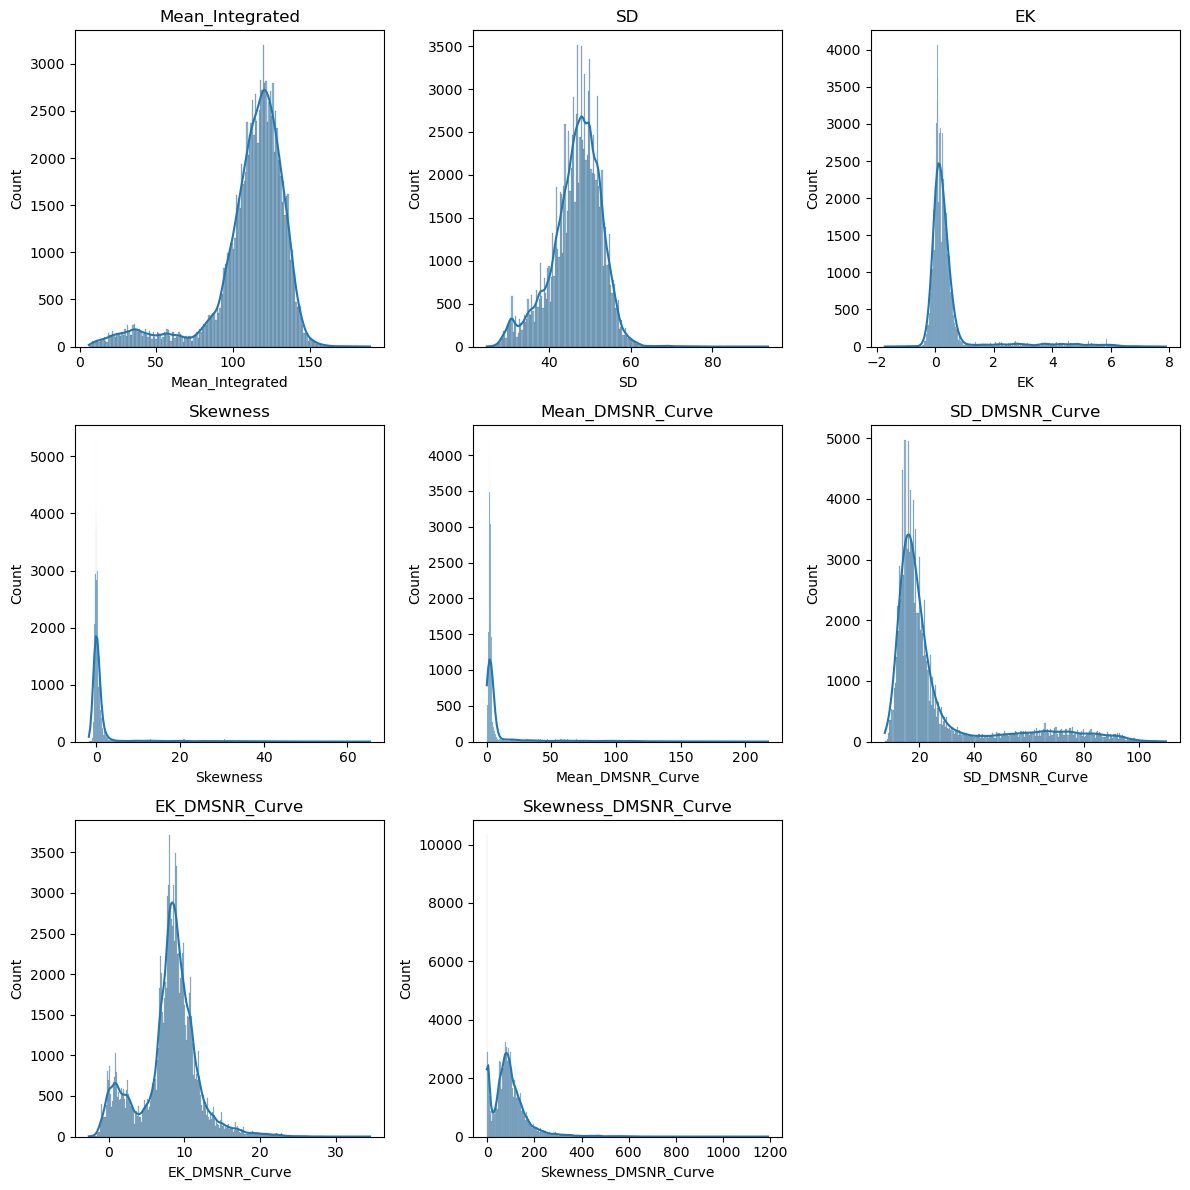

In [64]:
fig, axes = plt.subplots(ncols = 3, nrows = 3, figsize = (12,12))
for i, ax in enumerate(axes.flat):
    if i < len(['Mean_Integrated', 'SD', 'EK', 'Skewness', 'Mean_DMSNR_Curve',
       'SD_DMSNR_Curve', 'EK_DMSNR_Curve', 'Skewness_DMSNR_Curve']):
        sns.histplot(x=  train[(['Mean_Integrated', 'SD', 'EK', 'Skewness', 'Mean_DMSNR_Curve',
       'SD_DMSNR_Curve', 'EK_DMSNR_Curve', 'Skewness_DMSNR_Curve'][i])], ax = ax, kde = True)
        ax.set_title(['Mean_Integrated', 'SD', 'EK', 'Skewness', 'Mean_DMSNR_Curve',
       'SD_DMSNR_Curve', 'EK_DMSNR_Curve', 'Skewness_DMSNR_Curve'][i])
    else:
        axes.flat[i].set_visible(False)
plt.tight_layout()
plt.show()

### Boxplot of predictor variables

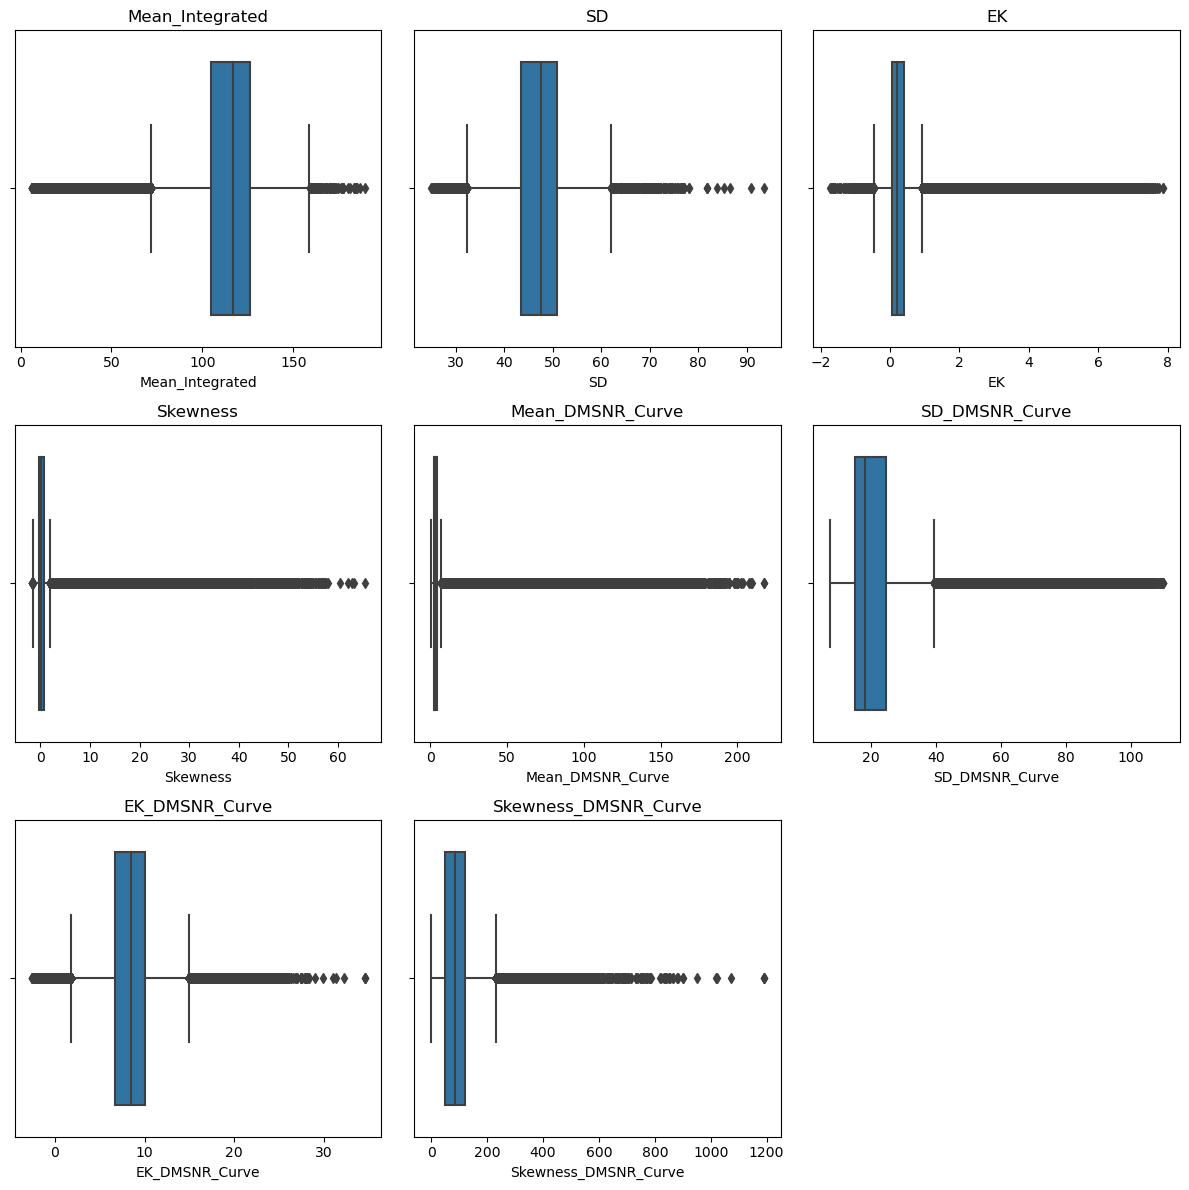

In [65]:
fig, axes = plt.subplots(ncols = 3, nrows = 3, figsize = (12,12))
for i, ax in enumerate(axes.flat):
    if i < len(['Mean_Integrated', 'SD', 'EK', 'Skewness', 'Mean_DMSNR_Curve',
       'SD_DMSNR_Curve', 'EK_DMSNR_Curve', 'Skewness_DMSNR_Curve']):
        sns.boxplot(x = train[(['Mean_Integrated', 'SD', 'EK', 'Skewness', 'Mean_DMSNR_Curve',
       'SD_DMSNR_Curve', 'EK_DMSNR_Curve', 'Skewness_DMSNR_Curve'][i])], ax=ax)
        ax.set_title(['Mean_Integrated', 'SD', 'EK', 'Skewness', 'Mean_DMSNR_Curve',
       'SD_DMSNR_Curve', 'EK_DMSNR_Curve', 'Skewness_DMSNR_Curve'][i])
    else:
        axes.flat[i].set_visible(False)
plt.tight_layout()
plt.show()
        

### Plotting the target variable

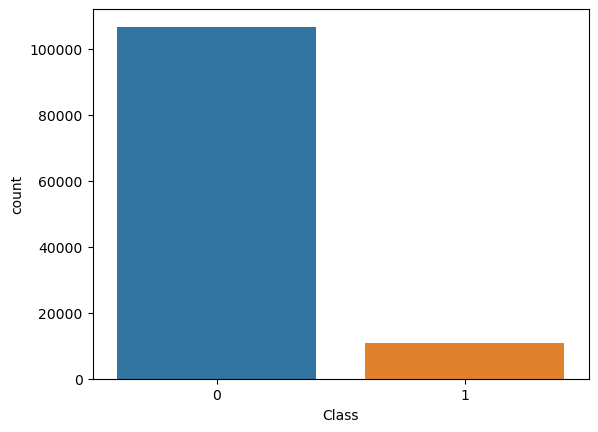

In [66]:
sns.countplot(x = train.Class)
plt.show()

### Separating features and target variable

In [67]:
y = train.Class
train.drop(columns = ['Class'], inplace = True)

### Standardizing the predcitor variables

In [68]:
ss = StandardScaler()
train = pd.DataFrame(ss.fit_transform(train), columns = train.columns)
test = pd.DataFrame(ss.transform(test), columns = test.columns)

### Optuna parameter tuning- XG Boost

In [ ]:
def obj_xgboost(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01,1),
        'n_estimators': trial.suggest_int('n_estimators', 100, 500), 
        'gamma': trial.suggest_float('gamma', 1e-8, 1),
        'min_child_weight': trial.suggest_int('min_child_weight', 1,10),
        'subsample': trial.suggest_float('subsample', 0.01,1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01,1),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8,1), 
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8,1)
    }
    scores = []
    optuna_model = XGBClassifier(**params)
    cv = KFold(n_splits = 10,  shuffle = True, random_state = 0)
    for train_index, test_index in cv.split(train, y):
        trainx, testx = train.iloc[train_index], train.iloc[test_index]
        trainy, testy = y[train_index], y[test_index]
        optuna_model.fit(trainx, trainy)
        predy = optuna_model.predict_proba(testx)
        scores.append(metrics.log_loss(testy, predy))
    return np.mean(scores)
study_xg = optuna.create_study(direction = 'minimize')
optuna.logging.set_verbosity(optuna.logging.WARNING)
n_trials = 25
with tqdm(total = n_trials) as pbar:
    for i in range(n_trials):
        study_xg.optimize(obj_xgboost, n_trials = 1)
        pbar.update(1)
        

### Optuna parameter tuning- Light GBM

In [ ]:
def obj_lgbm(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01,1),
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.01,1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01,1),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8,1),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8,1)
    }
    scores = []
    optuna_model = LGBMClassifier(**params)
    cv = KFold(n_splits = 10, shuffle = True, random_state = 0)
    for train_index, test_index in cv.split(train, y):
        trainx, testx = train.iloc[train_index], train.iloc[test_index]
        trainy, testy = y[train_index], y[test_index]
        optuna_model.fit(trainx, trainy)
        predy = optuna_model.predict_proba(testx)
        scores.append(metrics.log_loss(testy, predy))
    return np.mean(scores)
study_lgbm = optuna.create_study(direction = 'minimize')
n_trials = 50
with tqdm(total = n_trials) as pbar:
    for i in range(n_trials):
        study_lgbm.optimize(obj_lgbm, n_trials= 1)
        pbar.update(1)        

### Optuna parameter tuning- Cat Boost

In [ ]:
def obj_cat(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100,500),
        'learning_rate': trial.suggest_float('learning_rate', 1e-8, 1),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.01,0.1),
        'depth': trial.suggest_int('depth', 1, 10)
    }
    scores = []
    cv = KFold(n_splits = 10, shuffle = True, random_state = 0)
    optuna_model = CatBoostClassifier(**params, verbose = False)
    for train_index, test_index in cv.split(train,y):
        trainx, testx = train.iloc[train_index], train.iloc[test_index]
        trainy, testy = y[train_index], y[test_index]
        optuna_model.fit(trainx, trainy)
        predy = optuna_model.predict_proba(testx)
        scores.append(metrics.log_loss(testy, predy))
    return np.mean(scores)
study_cat = optuna.create_study(direction = 'minimize')
optuna.logging.set_verbosity(optuna.logging.WARNING)
n_trials = 50
with tqdm(total = n_trials) as pbar:
    for i in range(n_trials):
        study_cat.optimize(obj_cat, n_trials = 1)
        pbar.update(1)

### Predicting the probabilities for the test set

In [ ]:
cv = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 0)
pred_xgb = np.zeros(test.shape[0])
pred_lgbm = np.zeros(test.shape[0])
pred_cat =  np.zeros(test.shape[0])
score_xgb = []
score_lgbm = []
score_cat = []

for train_index, test_index in cv.split(train, y):
    trainx, testx = train.iloc[train_index], train.iloc[test_index]
    trainy, testy =  y[train_index], y[test_index]
    
    model_xgb = XGBClassifier(early_stopping_rounds = 100, **study_xg.best_params)
    model_xgb.fit(trainx, trainy, eval_set = [(testx, testy)], verbose = False)
    predy = model_xgb.predict_proba(testx)[:, 1]
    pred_xgb+=model_xgb.predict_proba(test)[:, 1]/cv.n_splits
    score_xgb.append(metrics.log_loss(testy, predy))
    
    model_lgbm = LGBMClassifier(early_stopping_rounds = 100, **study_lgbm.best_params)
    model_lgbm.fit(trainx, trainy, eval_set = [(testx, testy)], verbose = False)
    predy = model_lgbm.predict_proba(testx)[:, 1]
    pred_lgbm+=model_lgbm.predict_proba(test)[:, 1]/cv.n_splits
    score_lgbm.append(metrics.log_loss(testy, predy))
    
    model_cat = CatBoostClassifier(early_stopping_rounds = 100, **study_cat.best_params)
    model_cat.fit(trainx, trainy, eval_set = [(testx, testy)], verbose = False)
    predy = model_cat.predict_proba(testx)[:, 1]
    pred_cat+=model_cat.predict_proba(test)[:, 1]/cv.n_splits
    score_cat.append(metrics.log_loss(testy, predy))

In [ ]:
submission = pd.read_csv('/kaggle/input/playground-series-s3e10/test.csv')
submission['XGB'] = pred_xgb
submission['Class'] = submission['XGB']
final_submission = pd.DataFrame(submission, columns=['id', 'Class'])
final_submission.to_csv('predcitions.csv', index = False)

In [ ]:
submission['CAT'] = pred_cat
submission['Class'] = submission['CAT']
final_submission = pd.DataFrame(submission, columns=['id', 'Class'])
final_submission.to_csv('predcitions.csv', index = False)

In [ ]:
submission['LGBM'] = pred_lgbm
submission['Class'] = submission['LGBM']
final_submission = pd.DataFrame(submission, columns=['id', 'Class'])
final_submission.to_csv('predcitions.csv', index = False)